<h1 style="font-size:30px;">Training the ASL Classifier using VGG-16</h1>  

In this notebook, we starting with a model pre-trained for imagenet, and adapt it for a different dataset: American Sign Language (ASL). We instantiate the feature extractor of the VGG-16 network architecture using pre-trained weights from the ImageNet dataset. Then we add our own classifier and re-trian the model on the ASL dataset.

**The standard training technique is summarized below:**

1. Instantiate the VGG-16 convolutional base with pre-trained weights from ImageNet
2. Add our custom classifier layer for the ASL dataset
3. Train the model (all layers)

<img src='https://github.com/AlbertaBeef/asl_tutorial/raw/2022.2/images/VGG16_04_asl_training.png' width=1000 align='center'><br/>

## Table of Contents
* [1 System Configuration](#1-System-Configuration)
* [2 Download and Extract the Dataset](#2-Download-and-Extract-the-Dataset)
* [3 Dataset and Training Configuration](#3-Dataset-and-Training-Configuration)
* [4 Training the Model](#4-Training-the-Model)
* [5 Model Evaluation](#5-Model-Evaluation)
* [6 Conclusion](#6-Conclusion)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import zipfile
import requests
import glob as glob

from tensorflow.keras.utils import image_dataset_from_directory

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass 

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)
SEED_VALUE = 42 

## 1 System Configuration

In [2]:
def system_config():
    
    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)
    
    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
        
        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
        
        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        
        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Using GPU


## 2 Download and Extract the Dataset

In [3]:
def download_file(url, save_name):
    url = url
    file = requests.get(url)

    open(save_name, 'wb').write(file.content)

In [4]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [5]:
#download_file(
#    'https://www.dropbox.com/s/7huaqeavdbz32la/dataset_ASL_150.zip?dl=1', 
#    'dataset_ASL_150.zip'
#)
#    
#unzip(zip_file='dataset_ASL_150.zip')

## 3 Dataset and Training Configuration

In [6]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 29
    IMG_HEIGHT:  int = 224
    IMG_WIDTH:   int = 224
    CHANNELS:    int = 3
    BATCH_SIZE:  int = 64
    DATA_ROOT:   str = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
        
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:     int   = 64
    EPOCHS:         int   = 51
    LEARNING_RATE:  float = 0.001
    CHECKPOINT_DIR: str   = './saved_models_asl_classifier1'

## 4 Training the Model

The Keras API provides the following utility that is used to instantiate a VGG-16 model, which can be initialized with either pre-trained weights from ImageNet or random initial weights. **In this notebook, we will load the model with weights from the ImageNet dataset** as a starting point for **Training.** For more information on the VGG-16 model available in Keras, refer to the: <a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16" target="_blank">Keras VGG-16 Model API</a>

```python
tf.keras.applications.vgg16.VGG16(include_top=True, 
                                  weights='imagenet', 
                                  input_tensor=None,
                                  input_shape=None, 
                                  pooling=None, 
                                  classes=1000,
                                  classifier_activation='softmax',
                                 )
```

<img src='https://github.com/AlbertaBeef/asl_tutorial/raw/2022.2/images/VGG16_01_imagenet.png' width=1000 align='center'><br/>

In [7]:
print('Create an VGG16 model along with the imagenet pre-trained weights.')
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)
vgg16_model = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                include_top=True,
                                                weights='imagenet',
                                               )

Create an VGG16 model along with the imagenet pre-trained weights.
553467096/553467096 [==============================] - 3s 0us/step


In [8]:
print(vgg16_model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     


### 4.1 VGG Convolutional Base
We begin by creating a model of the VGG-16 convolutional base. We can do this by instantiating the model and setting `include_top = False`, which excludes the fully connected layers. In this notebook, we will instantiate the model with weights that were learned by training the model on the ImageNet dataset.

<img src='https://github.com/AlbertaBeef/asl_tutorial/raw/2022.2/images/VGG16_10_pretrained_base.png' width=1000 align='center'><br/>

In [9]:
print('Create an VGG16 model along with the imagenet pre-trained weights.')
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)
vgg16_model_base = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                    include_top=False,
                                                    weights='imagenet',
                                                   )

Create an VGG16 model along with the imagenet pre-trained weights.
58889256/58889256 [==============================] - 0s 0us/step


In [10]:
print(vgg16_model_base.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### 4.3 Add the Classification Layer
Since we intend to train and use the model to classify hand signals from the ASL dataset (which has 29 classes), we will need to add our own classification layer. In this example, we have chosen to use just a single fully connected dense layer that contains 256 nodes, followed by a softmax output layer that contains 29 nodes for each of the 29 classes. The number of dense layers and the number of nodes per layer is a design choice, but the number of nodes in the output layer must match the number of classes in the dataset.

<img src='https://github.com/AlbertaBeef/asl_tutorial/raw/2022.2/images/VGG16_03_asl_vitis_ai.png' width=1000 align='center'><br/>

In [11]:
print('Add Classification Layers (output or top)')
# Take the output of the VGG16 just before last layer
x = vgg16_model_base.layers[-1].output

# reduce the size of the last layer (7x7x512=25088)
# to account for conv2d/dense limitations in Vitis-AI
#x = tf.keras.layers.Conv2D(1024, (7, 7),name='block6_conv')(x)
#x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.MaxPooling2D()(x)
    
# Flatten the outputs of the last conv layer
flatten = tf.keras.layers.Flatten(name='flatten')(x)

# Fully Connected layers.
dense = tf.keras.layers.Dense(256, activation= 'relu',name='fc')(flatten)

# adding the prediction layer with 'softmax'
predictions = tf.keras.layers.Dense(DatasetConfig.NUM_CLASSES, activation='softmax',name='predictions')(dense)
    
# Create the new model with the new outputs
model = tf.keras.Model(inputs=vgg16_model_base.input, outputs=predictions)

Add Classification Layers (output or top)


In [12]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### 4.4 Prepare the Training and Validation Dataset

In [13]:
train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                             subset='training',
                                             validation_split=0.2
                                            )

valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                             subset='validation',
                                             validation_split=0.2
                                            )

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


### 4.6 Display Sample Images

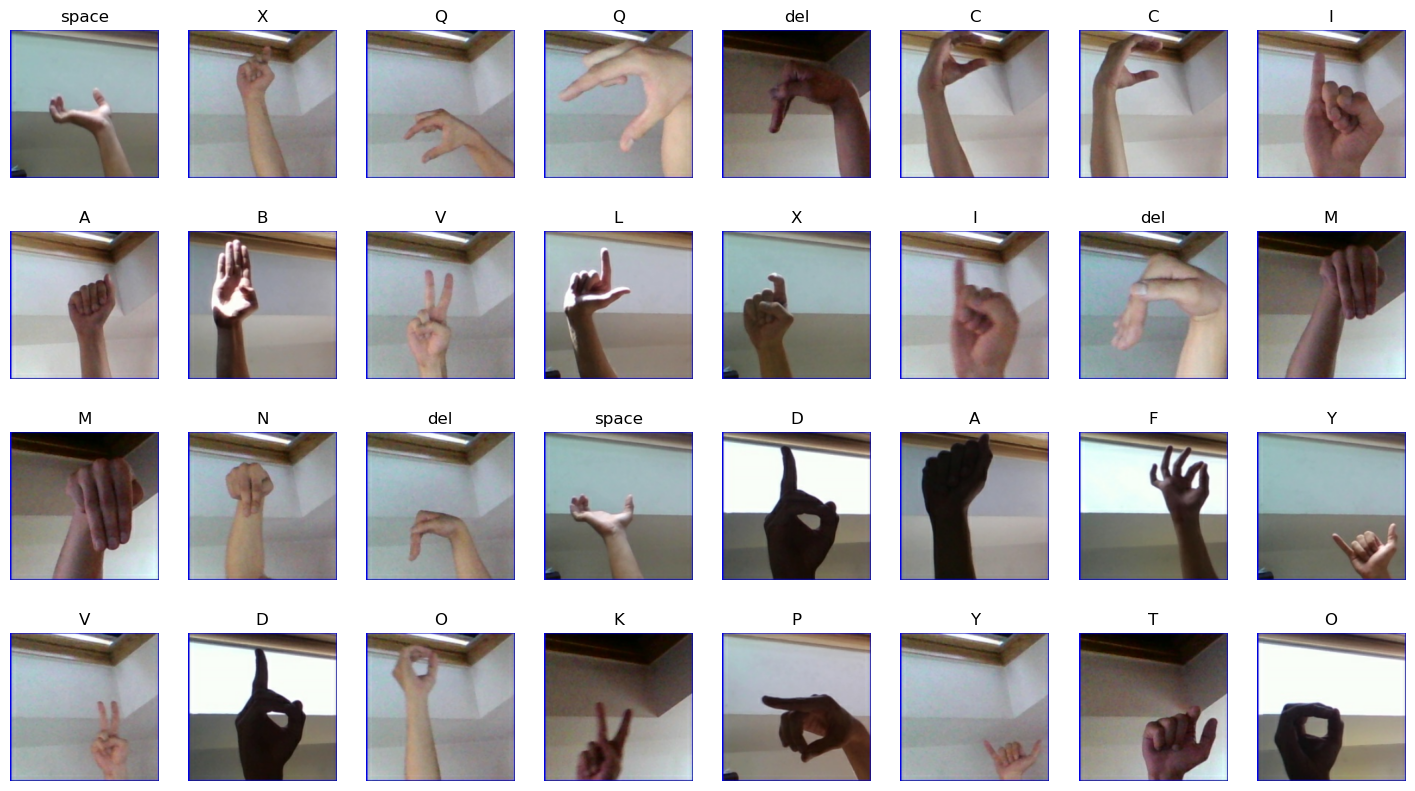

In [14]:
class_names = train_dataset.class_names

plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in train_dataset.take(1): 
    
    # For the batch of images and the associated (one-hot encoded) labels, 
    # plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = np.nonzero(labels_batch[i].numpy())
        plt.title(class_names[truth_idx[0][0]])
        plt.axis("off")

### 4.6 Compile and Train the Model

<img src='https://github.com/AlbertaBeef/asl_tutorial/raw/2022.2/images/VGG16_04_asl_training.png' width=1000 align='center'><br/>

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'],
                   )

In [16]:
# Save best model based on highest validation_accuracy.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=TrainingConfig.CHECKPOINT_DIR,
                                                               save_weights_only=False,
                                                               monitor='val_accuracy',
                                                               mode='max',
                                                               save_best_only=True,
                                                              )

In [17]:
print(f"Model evaluation accuracy: {model.evaluate(valid_dataset)[1]*100.:.3f}")

272/272 [==============================] - 103s 308ms/step - loss: 34.1654 - accuracy: 0.0271
Model evaluation accuracy: 2.713


In [18]:
from datetime import datetime

# datetime object containing current date and time
timestamp1 = datetime.now()
print(timestamp1)

2023-04-19 17:16:41.976345


In [ ]:
# Train the Model.
training_results = model.fit(train_dataset,
                                   validation_data=valid_dataset,
                                   epochs=TrainingConfig.EPOCHS,
                                   workers=4,
                                   use_multiprocessing=True, 
                                   callbacks=model_checkpoint_callback,
                                  )

Epoch 1/51
1017/1088 [===========================>..] - ETA: 53s - loss: 3.5012 - accuracy: 0.0344

In [ ]:
timestamp2 = datetime.now()
print(timestamp2)

print(timestamp2-timestamp1)

### 4.8 Plot the Training Results

In [ ]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show(block=block_plot)
    plt.close()

In [ ]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]
    
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.5, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])
 
max_loss = 2.0

plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, max_loss],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

## 5 Model Evaluation

In [ ]:
# Load saved model.
# Final evaluation accuracy on the validation set.
model = tf.keras.models.load_model(TrainingConfig.CHECKPOINT_DIR)
print(f"Model evaluation accuracy: {model.evaluate(valid_dataset)[1]*100.:.3f}")

In [ ]:
def display_wrong_predictions(dataset, checkpoint_dir=None, checkpoint_version=0):
    
    if not checkpoint_dir:
        checkpoint_dir = os.path.join(os.getcwd(), TrainingConfig.checkpoint_dir, f"version_{checkpoint_version}")
        
    # Load saved model.
    model = tf.keras.models.load_model(checkpoint_dir)
    
    plt.figure(figsize=(20, 15))
    num_rows = 4
    num_cols = 5
    class_names = dataset.class_names
    jdx = 0
    
    # Evaluate all the batches.
    for image_batch, labels_batch in dataset:
        
        # Predictions for the current batch.
        predictions = model.predict(image_batch)
        
        # Loop over all the images in the current batch.
        for idx in range(len(labels_batch)):
            
            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = np.nonzero(labels_batch[idx].numpy())
            
            # Plot the images with incorrect predictions
            if pred_idx != truth_idx:
                
                jdx += 1
                
                if jdx > num_rows*num_cols:
                    # Break from the loops if the maximum number of images have been plotted
                    break
                
                ax = plt.subplot(num_rows, num_cols, jdx)
                title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
                title_obj = plt.title(title)
                plt.setp(title_obj, color='r')
                plt.axis("off")
                plt.imshow(image_batch[idx].numpy().astype("uint8"))
    return  

In [ ]:
display_wrong_predictions(valid_dataset, TrainingConfig.CHECKPOINT_DIR)

## 6 Conclusion

In this notebook, we showed how you can use **fine-tuning** to make adjustments to the weights in the last few layers of a pre-trained convolutional base to improve the validation accuracy of the model. This is a very common technique that is used to leverage pre-existing models for new datasets. When using this approach, it is recommended that you first train the dense classifier only and then un-freeze the layers in the convolutional base that you wish to fine-tune and the model again (including the dense classifier) at a lower learning rate. 

**Save model**

Once we are happy with the performance of the model, we can save it as a .h5 file, simply using the `save` method.

In [ ]:
model.save('tf2_asl_classifier1.h5')

**Load model**

Load model for the rest of the tutorial with the `load_model` method.

In [ ]:

model = keras.models.load_model('tf2_asl_classifier1.h5')
